### Bonk nitrogen estimation

### Defining libraies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC,SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score
import itertools
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from evolutionary_search import EvolutionaryAlgorithmSearchCV
from scipy.stats import randint as sp_randint
import scipy.stats as stats
from random import randrange as sp_randrange
from math import sqrt
warnings.filterwarnings('ignore')
np.set_printoptions(precision=2)
%matplotlib inline

### Loading the dataset- Multispectral characteristics of the soil and crops in red, near-infrared, and green spectral bands, computedvegetation indices. Building a model from paper's dataset


In [ ]:
!wget https://raw.githubusercontent.com/abirhossen786/ums/main/dataset_multispectral_features.csv

--2022-04-23 17:50:35--  https://raw.githubusercontent.com/abirhossen786/ums/main/dataset_multispectral_features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2327 (2.3K) [text/plain]
Saving to: ‘dataset_multispectral_features.csv’

dataset_multispectr 100%[===================>]   2.27K  --.-KB/s    in 0s      

2022-04-23 17:50:35 (39.6 MB/s) - ‘dataset_multispectral_features.csv’ saved [2327/2327]



In [ ]:
df = pd.read_csv('dataset_multispectral_features.csv')
df.head(5)

,RED (DN),NIR (DN),Green (DN),ndvi,RH (%),Temp (C),Nitrogen (ppm)
0,47.88,328.05,54.90,0.74,33.8,23.2,1179.39
1,51.99,329.97,56.50,0.72,33.8,23.2,1136.64
2,52.37,325.90,56.14,0.72,33.8,23.2,1093.90
3,55.81,200.32,43.11,0.56,33.8,23.2,418.46
4,59.30,209.11,45.47,0.55,33.8,23.2,413.75


### Defining inputs and target

In [ ]:
input_ndvi = df['ndvi']
input_red = df['RED (DN)']
input_NIR = df['NIR (DN)']
input_Green = df['Green (DN)']
X_input = np.array([input_ndvi, input_red,  input_NIR, input_Green])
X_input = X_input.transpose()
Y_target = np.array(df['Nitrogen (ppm)'])
#print(X_input)

carica immagine alberto

### HOW TO OPEN TIFF

In [ ]:
from osgeo import gdal
im = gdal.Open(r'/content/PermanentCrop_7.tif')
print(im.RasterCount)
b8 = im.GetRasterBand(8)
b8 = b8.ReadAsArray()
print(b8.shape)
b4 = im.GetRasterBand(4)
b4 = b4.ReadAsArray()
b3 = im.GetRasterBand(3)
b3 = b3.ReadAsArray()
plt.imshow(b8)

build pd dataframe
i need 3-4-8
and compute NDVI

In [ ]:
#b3 = cv2.imread("./content/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B3.bmp", 0)
#b4 = cv2.imread("./content/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B4.bmp",0)
#b8 = cv2.imread("./content/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B8.bmp",0)

#flatten
dum1 = np.array(b3) 
dum2 =np.array(b4) 
dum3 =np.array(b8) 

flat3 = dum1.flatten()
flat4 =dum2.flatten()
flat8 =dum3.flatten()


NVIDnum = np.subtract(flat8,flat4,dtype=np.int16)
NVIDden = np.add(flat4,flat8,dtype=np.int16)
NVIDden = NVIDden.astype('float')
NVIDden[NVIDden==0] = 0.1
#just some checks
n_zero = np.count_nonzero(NVIDden)
print(n_zero, "NONZER")
print(NVIDden.shape)
NVID = np.divide(NVIDnum,NVIDden)
nan = np.count_nonzero(np.isnan(NVID))
print(nan,"NAN number")


df1 = pd.DataFrame({"NVID":NVID,"RED":flat4,'NIR':flat8, "G":flat3})
print(df1.shape)

dfpredict = df1[(df1.NIR != 51) & (df1.RED !=51) & (df1.G!=51)]
print(dfpredict.shape,"dataframe without useless")

dfpredict = dfpredict.dropna()
print("dataframw without nans",dfpredict.shape)
dfpredict.head(100)

4096 NONZER
(4096,)
0 NAN number
(4096, 4)
(4096, 4) dataframe without useless
dataframw without nans (4096, 4)


,NVID,RED,NIR,G
0,0.265384,1355,2334,1117
1,0.265384,1355,2334,1117
2,0.132985,1744,2279,1205
3,0.119286,1628,2069,1126
4,0.100304,1628,1991,1124
...,...,...,...,...
95,0.131876,1886,2459,1330
96,0.149267,1858,2510,1336
97,0.175220,1784,2542,1282
98,0.183740,1757,2548,1308


### Test-train data split THIS IS FOR MODEL TRAINING AND EVALUATION

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_input, Y_target, train_size=0.80, test_size=0.20, random_state=123)
print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Train/Test Sizes :  (43, 4) (11, 4) (43,) (11,)


### ML model, hyper-parameter optimization

#### MLP Default. Not working well, we will go with random search

RMSE: 177.84
Actual: [673.15 844.87 621.91 889.85 897.75 563.82 592.87 718.12 531.8  542.67]
Predicted: [825.18 940.51 804.65 879.33 798.13 871.27 714.6  768.14 712.79 629.84]


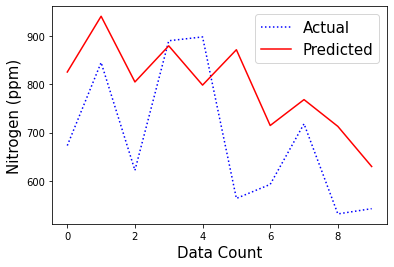

CPU times: user 286 ms, sys: 5.89 ms, total: 292 ms
Wall time: 294 ms


In [ ]:
%%time

mlp_regressor  = MLPRegressor(random_state=123)
mlp_regressor.fit(X_train, Y_train)
Y_preds = mlp_regressor.predict(X_test)
test_rmse_MLP_default = sqrt(mean_squared_error(Y_test, Y_preds))

mlp_default_actual = Y_test[:10]
mlp_default_predicted = Y_preds[:10]

print("RMSE:", np.round(test_rmse_MLP_default,2))
print("Actual:", mlp_default_actual)
print("Predicted:", mlp_default_predicted)
# Predict for test data
plt.plot(mlp_default_actual, ':', color='b', label='Actual')
plt.plot(mlp_default_predicted,  color='r',  label='Predicted')
plt.legend(prop={'size': 15})
plt.ylabel('Nitrogen (ppm)', fontsize=15)
plt.xlabel('Data Count', fontsize=15)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

#### MLP RandomSearch

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters:  {'activation': 'tanh', 'hidden_layer_sizes': 112, 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
RMSE: 147.86
Actual: [673.15 844.87 621.91 889.85 897.75 563.82 592.87 718.12 531.8  542.67]
Predicted: [855.78 730.03 886.89 891.13 787.51 597.66 714.3  801.12 583.12 582.36]


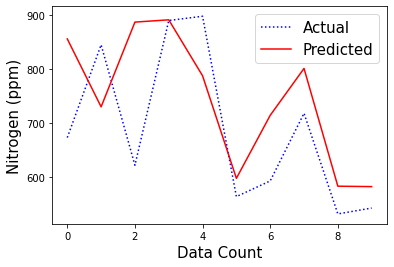

CPU times: user 781 ms, sys: 52.4 ms, total: 833 ms
Wall time: 9.49 s


In [ ]:
%%time
params = {'activation': ['relu', 'tanh', 'logistic', 'identity'],
          'hidden_layer_sizes': sp_randint(10, 150),
          'solver': ['lbfgs', 'adam'],
          'learning_rate' : ['constant', 'adaptive', 'invscaling'],
         }

n_iter_search=25

mlp_regressor_random = RandomizedSearchCV(MLPRegressor(random_state=123), param_distributions=params, n_iter=n_iter_search, cv=5, verbose=5,n_jobs=-1)
mlp_regressor_random.fit(X_train,Y_train)
MLP_r2_score_random = mlp_regressor_random.best_estimator_.score(X_test, Y_test)
test_rmse_MLP_random = sqrt(mean_squared_error(Y_test, mlp_regressor_random.predict(X_test)))

print('Best Parameters: ',mlp_regressor_random.best_params_)
print("RMSE:", np.round(test_rmse_MLP_random,2))

# Predict for test data
Y_preds = mlp_regressor_random.predict(X_test)
mlp_random_predicted = Y_preds[:10]
mlp_random_actual = Y_test[:10]
print("Actual:", mlp_random_actual)
print("Predicted:", mlp_random_predicted)
plt.plot(mlp_random_actual, ':', color='b', label='Actual')
plt.plot(mlp_random_predicted, color='r', label='Predicted')
plt.legend(prop={'size': 15})
plt.ylabel('Nitrogen (ppm)', fontsize=15)
plt.xlabel('Data Count', fontsize=15)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

### Now prediction and generalization

[586.11 586.13 586.11 586.11 586.11 586.11 586.11 586.11 586.25 604.57
 605.13 605.13 586.36 586.11 586.11 586.11 586.11 586.11 586.11 586.11
 586.11 586.12 586.11 586.11 586.59 605.22 609.83 641.28 645.86 665.34
 657.43 644.11 643.92 605.21 592.02 593.86 593.63 593.46 590.99 586.35
 605.18 610.45 639.17 644.72 627.88 618.75 637.55 642.15 616.77 644.53
 628.35 605.28 696.   647.43 623.99 620.43 806.77 806.77 694.36 719.08
 605.03 586.16 586.11 586.11 586.11 586.11 586.11 586.11 586.11 586.11
 586.11 586.11 586.11 586.12 604.26 605.13 605.   586.11 586.11 586.11
 586.11 586.11 586.11 586.11 586.11 586.11 586.13 586.22 605.35 605.24
 607.63 645.4  664.15 651.92 649.78 651.72 654.37 639.87 605.17 601.03]


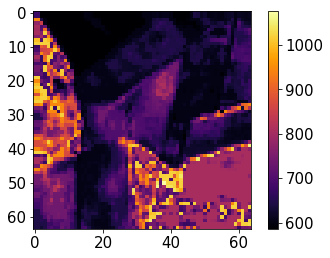

In [ ]:
N_predict = mlp_regressor_random.predict(df1)
print(N_predict[200:300])

new_img = N_predict.reshape(64,64)
plt.imshow(new_img,cmap="inferno")
plt.colorbar()
plt.savefig("permanentCrop_7_MLP.jpeg")
plt.show()


<Figure size 432x288 with 0 Axes>

### example of condition

In [ ]:
mean = np.mean(N_predict)
print(mean)
if mean < 200:
  print("Fertilization strongly reccomended !")
  elif (mean >200 & mean <600):
    print("moderate Fertilization may be neede")
    else:
      print("All is good! no fertilizers are needed! enjoy !")


SyntaxError: ignored

### alternative visualization

In [ ]:
new_img_norm = new_img/np.max(new_img)
new_img_grayscale = new_img_norm*255
new_img_grayscale = new_img_grayscale.astype("int")

In [ ]:
test = new_img_grayscale.copy().astype("uint8")
test[test < 100] = 0
test = test + np.ones(test.shape)*10
test[test > 255] = 255
test = test.astype("uint8")
test = cv2.GaussianBlur(test,(5,5),0)

In [ ]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [ ]:
test = new_img_grayscale.copy().astype("uint8")
test = (255-test)
test = apply_brightness_contrast(test, brightness=20, contrast=0)

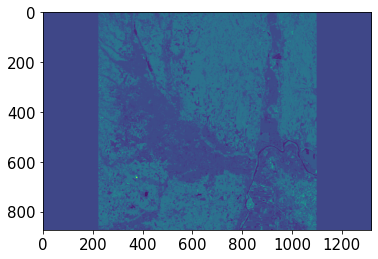

In [ ]:
plt.imshow(test)
plt.show()

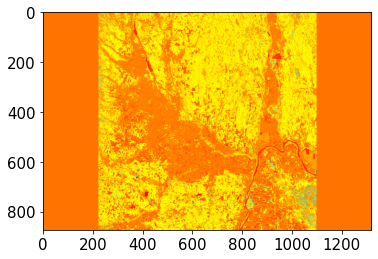

In [ ]:
test = cv2.applyColorMap(test, cv2.COLORMAP_JET)
plt.imshow(test)
plt.show()

In [ ]:
colored = np.dstack([b4, b3, b2]).astype(np.uint8)
output = cv2.addWeighted(test, 0.5, colored, 0.5, 0)

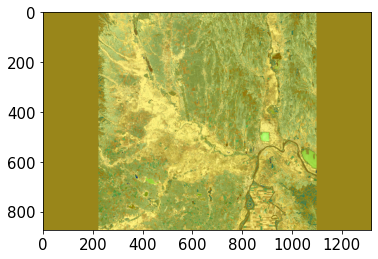

In [ ]:
plt.imshow(output)
plt.show()

#### MLP GeneticAlgorithm

Types [1, 1, 1, 1] and maxint [3, 139, 1, 2] detected
--- Evolve in 3360 possible combinations ---
[CV] activation=identity, hidden_layer_sizes=102, solver=adam, learning_rate=invscaling 
[CV]  activation=identity, hidden_layer_sizes=102, solver=adam, learning_rate=invscaling, score=-0.112, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=102, solver=adam, learning_rate=invscaling 
[CV]  activation=identity, hidden_layer_sizes=102, solver=adam, learning_rate=invscaling, score=-4.054, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=102, solver=adam, learning_rate=invscaling 
[CV]  activation=identity, hidden_layer_sizes=102, solver=adam, learning_rate=invscaling, score=-1.186, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=102, solver=adam, learning_rate=invscaling 
[CV]  activation=identity, hidden_layer_sizes=102, solver=adam, learning_rate=invscaling, score=-0.960, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=102, solver=adam, learning_r

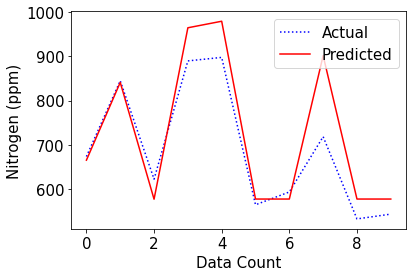

Wall time: 9.51 s


In [ ]:
%%time
params = {'activation': ['relu', 'tanh', 'logistic', 'identity'],
          'hidden_layer_sizes': range(10, 150),
          'solver': ['lbfgs', 'adam'],
          'learning_rate' : ['constant', 'adaptive', 'invscaling'],
         }

mlp_regressor = MLPRegressor(random_state=123)
mlp_regressor_genetic = EvolutionaryAlgorithmSearchCV(estimator=mlp_regressor,
                                   params=params,
                                   cv=5,
                                   verbose=5,
                                   population_size=20,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)

mlp_regressor_genetic.fit(X_input, Y_target)
test_rmse_MLP_genetic = sqrt(mean_squared_error(Y_test, mlp_regressor_genetic.predict(X_test)))
rmspe_GA = (sqrt(np.mean(np.square((Y_test - mlp_regressor_genetic.predict(X_test)) / Y_test)))) * 100

print(mlp_regressor_genetic.best_params_)
print('Best Parameters : ',mlp_regressor_genetic.best_params_)
print("RMSE:", np.round(test_rmse_MLP_genetic,2))
print("RMSPE: ",rmspe_GA)

# Predict for test data
Y_preds = mlp_regressor_genetic.predict(X_test)
mlp_genetic_predicted = Y_preds[:10]
mlp_genetic_actual = Y_test[:10]
print("Actual:", mlp_genetic_actual)
print("Predicted:", mlp_genetic_predicted)
plt.plot(mlp_genetic_actual, ':', color='b', label='Actual')
plt.plot(mlp_genetic_predicted, color='r', label='Predicted')
plt.legend(prop={'size': 15})
plt.ylabel('Nitrogen (ppm)', fontsize=15)
plt.xlabel('Data Count', fontsize=15)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

#### SVM Deafult

RMSE: 215.84
Actual: [673.15 844.87 621.91 889.85 897.75 563.82 592.87 718.12 531.8  542.67]
Predicted: [831.97 833.95 833.09 834.04 833.11 833.   831.99 831.61 831.61 831.05]


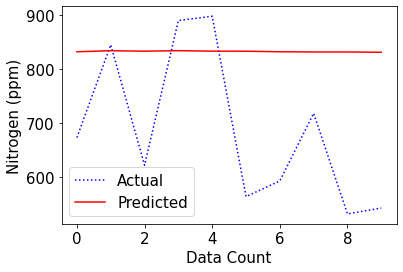

Wall time: 85 ms


In [ ]:
%%time
support_reg = SVR(gamma='scale')
support_reg.fit(X_train, Y_train)
Y_preds = support_reg.predict(X_test)
test_rmse_SVM_default = sqrt(mean_squared_error(Y_test, support_reg.predict(X_test)))
Y_preds = support_reg.predict(X_test)

print("RMSE:", np.round(test_rmse_SVM_default,2))

# Predict for test data
svm_default_predicted = Y_preds[:10]
svm_default_actual = Y_test[:10]
print("Actual:", svm_default_actual)
print("Predicted:", svm_default_predicted)
plt.plot(svm_default_actual, ':', color='b', label='Actual')
plt.plot(svm_default_predicted, color='r', label='Predicted')
plt.legend(prop={'size': 15})
plt.ylabel('Nitrogen (ppm)', fontsize=15)
plt.xlabel('Data Count', fontsize=15)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

#### SVM GridSearch

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best Parameters :  {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
RMSE: 169.59
Actual: [673.15 844.87 621.91 889.85 897.75 563.82 592.87 718.12 531.8  542.67]
Predicted: [747.06 856.16 813.9  866.09 805.51 807.63 746.93 718.22 724.03 689.32]


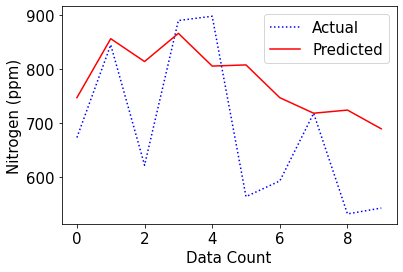

CPU times: user 632 ms, sys: 65.6 ms, total: 698 ms
Wall time: 1.86 s


In [ ]:
%%time
params = {
    'C': [1, 10, 100, 1000, 10000],
    "kernel":['poly', 'rbf', 'sigmoid'],
    "epsilon":[0.0001, 0.001, 0.01, 0.1, 1]
}
support_reg = SVR(gamma = 'scale')
support_reg_grid = GridSearchCV(support_reg, param_grid=params, n_jobs=-1, cv=5, verbose=5, scoring='neg_mean_squared_error')
support_reg_grid.fit(X_input, Y_target)
test_rmse_SVM_grid = sqrt(mean_squared_error(Y_test, support_reg_grid.predict(X_test)))
Y_preds = support_reg_grid.predict(X_test)

print('Best Parameters : ',support_reg_grid.best_params_)
print("RMSE:", np.round(test_rmse_SVM_grid,2))

# Predict for test data
svm_grid_predicted = Y_preds[:10]
svm_grid_actual = Y_test[:10]
print("Actual:", svm_grid_actual)
print("Predicted:", svm_grid_predicted)
plt.plot(svm_grid_actual, ':', color='b', label='Actual')
plt.plot(svm_grid_predicted, color='r', label='Predicted')
plt.legend(prop={'size': 15})
plt.ylabel('Nitrogen (ppm)', fontsize=15)
plt.xlabel('Data Count', fontsize=15)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

#### SVM RandomSearch

Best Parameters :  {'C': 2753.220350608049, 'epsilon': 0.9561499067188841, 'kernel': 'rbf'}
RMSE: 155.79
Actual: [673.15 844.87 621.91 889.85 897.75 563.82 592.87 718.12 531.8  542.67]
Predicted: [770.71 843.91 814.78 890.81 804.84 831.41 685.15 719.61 661.8  543.63]


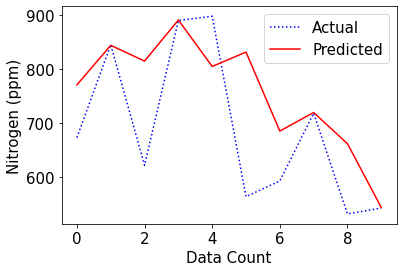

CPU times: user 412 ms, sys: 15.4 ms, total: 428 ms
Wall time: 602 ms


In [ ]:
%%time
params = {
    "C": stats.uniform(1,10000),
    "kernel":['poly','rbf','sigmoid'],
    "epsilon":stats.uniform(0.0001,1)
}

n_iter_search=30

support_reg = SVR(gamma='scale')
support_reg_random = RandomizedSearchCV(support_reg, param_distributions=params,n_iter=n_iter_search, n_jobs=-1,  cv=5,  scoring='neg_mean_squared_error')
support_reg_random.fit(X_input, Y_target)
test_rmse_SVM_random = sqrt(mean_squared_error(Y_test, support_reg_random.predict(X_test)))
Y_preds = support_reg_random.predict(X_test)

print('Best Parameters : ',support_reg_random.best_params_)
print("RMSE:", np.round(test_rmse_SVM_random,2))

# Predict for test data
svm_random_predicted = Y_preds[:10]
svm_random_actual = Y_test[:10]
print("Actual:", svm_random_actual)
print("Predicted:", svm_random_predicted)
plt.plot(svm_random_actual, ':', color='b', label='Actual')
plt.plot(svm_random_predicted, color='r', label='Predicted')
plt.legend(prop={'size': 15})
plt.ylabel('Nitrogen (ppm)', fontsize=15)
plt.xlabel('Data Count', fontsize=15)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

### trial with SVM. deprecated

Best Parameters :  {'C': 69.32807724538759, 'epsilon': 0.09978348312385434, 'kernel': 'rbf'}
RMSE: 177.96
Actual: [673.15 844.87 621.91 889.85 897.75 563.82 592.87 718.12 531.8  542.67]
Predicted: [763.71 850.9  818.68 859.61 812.01 812.37 766.37 741.28 747.71 721.43]


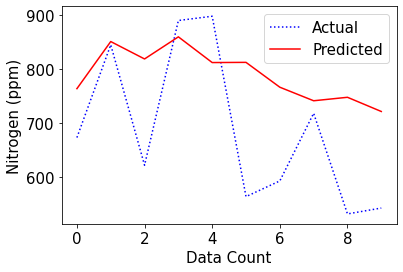

CPU times: user 410 ms, sys: 26.6 ms, total: 437 ms
Wall time: 1.35 s


In [ ]:
%%time
params = {
    "C": stats.uniform(1,10000),
    "kernel":['poly','rbf','sigmoid'],
    "epsilon":stats.uniform(0.0001,1)
}

n_iter_search=30

support_reg = SVR(gamma='scale')
support_reg_random = RandomizedSearchCV(support_reg, param_distributions=params,n_iter=n_iter_search, n_jobs=-1,  cv=5,  scoring='neg_mean_squared_error')
support_reg_random.fit(X_input, Y_target)
test_rmse_SVM_random = sqrt(mean_squared_error(Y_test, support_reg_random.predict(X_test)))
Y_preds = support_reg_random.predict(X_test)

print('Best Parameters : ',support_reg_random.best_params_)
print("RMSE:", np.round(test_rmse_SVM_random,2))

# Predict for test data
svm_random_predicted = Y_preds[:10]
svm_random_actual = Y_test[:10]
print("Actual:", svm_random_actual)
print("Predicted:", svm_random_predicted)
plt.plot(svm_random_actual, ':', color='b', label='Actual')
plt.plot(svm_random_predicted, color='r', label='Predicted')
plt.legend(prop={'size': 15})
plt.ylabel('Nitrogen (ppm)', fontsize=15)
plt.xlabel('Data Count', fontsize=15)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

### generalize and predict with SVM model

[803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41
 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41
 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41
 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41
 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41
 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41
 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41
 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41
 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41
 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41 803.41]


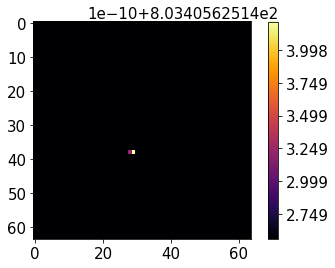

In [ ]:
N_predict = support_reg_random.predict(df1)
print(N_predict[200:300])

new_img = N_predict.reshape(64,64)
plt.imshow(new_img,cmap="inferno")
plt.colorbar()
plt.savefig("")
plt.show()